In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
np.random.seed(98765)

In [2]:
######################################
# Define 3 regression algorithms
######################################

def leastsq_ridge(X,Y,X1,ridge_mult=0.001):
    lam = ridge_mult * np.linalg.svd(X,compute_uv=False).max()**2
    betahat = np.linalg.solve(\
            np.c_[np.ones(X.shape[0]),X].T.dot(np.c_[np.ones(X.shape[0]),X]) \
                              + lam * np.diag(np.r_[0,np.ones(X.shape[1])]),
            np.c_[np.ones(X.shape[0]),X].T.dot(Y))
    return betahat[0] + X1.dot(betahat[1:])

def random_forest(X,Y,X1,ntree=20):
    rf = RandomForestRegressor(n_estimators=ntree,criterion='mae').fit(X,Y)
    return rf.predict(X1)

def neural_net(X,Y,X1):
    nnet = MLPRegressor(solver='lbfgs',activation='logistic').fit(X,Y)
    return nnet.predict(X1)


In [3]:
def compute_PIs(X,Y,X1,alpha,fit_muh_fun):
    n = len(Y)
    n1 = X1.shape[0]
       
    ###############################
    # Naive & jackknife/jack+/jackmm
    ###############################

    muh_vals = fit_muh_fun(X,Y,np.r_[X,X1])
    resids_naive = np.abs(Y-muh_vals[:n])
    muh_vals_testpoint = muh_vals[n:]
    resids_LOO = np.zeros(n)
    muh_LOO_vals_testpoint = np.zeros((n,n1))
    for i in range(n):
        muh_vals_LOO = fit_muh_fun(np.delete(X,i,0),np.delete(Y,i),\
                                   np.r_[X[i].reshape((1,-1)),X1])
        resids_LOO[i] = np.abs(Y[i] - muh_vals_LOO[0])
        muh_LOO_vals_testpoint[i] = muh_vals_LOO[1:]
    ind_q = (np.ceil((1-alpha)*(n+1))).astype(int)

    ###############################
    # CV+
    ###############################

    K = 10
    n_K = np.floor(n/K).astype(int)
    base_inds_to_delete = np.arange(n_K).astype(int)
    resids_LKO = np.zeros(n)
    muh_LKO_vals_testpoint = np.zeros((n,n1))
    for i in range(K):
        inds_to_delete = (base_inds_to_delete + n_K*i).astype(int)
        muh_vals_LKO = fit_muh_fun(np.delete(X,inds_to_delete,0),np.delete(Y,inds_to_delete),\
                                   np.r_[X[inds_to_delete],X1])
        resids_LKO[inds_to_delete] = np.abs(Y[inds_to_delete] - muh_vals_LKO[:n_K])
        for inner_K in range(n_K):
            muh_LKO_vals_testpoint[inds_to_delete[inner_K]] = muh_vals_LKO[n_K:]
    ind_Kq = (np.ceil((1-alpha)*(n+1))).astype(int)



    ###############################
    # split conformal
    ###############################
    
    idx = np.random.permutation(n)
    n_half = int(np.floor(n/2))
    idx_train, idx_cal = idx[:n_half], idx[n_half:]
    muh_split_vals = fit_muh_fun(X[idx_train],Y[idx_train],np.r_[X[idx_cal],X1])
    resids_split = np.abs(Y[idx_cal]-muh_split_vals[:(n-n_half)])
    muh_split_vals_testpoint = muh_split_vals[(n-n_half):]
    ind_split = (np.ceil((1-alpha)*(n-n_half+1))).astype(int)



    ###############################
    # construct prediction intervals
    ###############################
        
    PIs_dict = {'naive' : pd.DataFrame(\
                    np.c_[muh_vals_testpoint - np.sort(resids_naive)[ind_q-1], \
                        muh_vals_testpoint + np.sort(resids_naive)[ind_q-1]],\
                           columns = ['lower','upper']),\
                'jackknife' : pd.DataFrame(\
                    np.c_[muh_vals_testpoint - np.sort(resids_LOO)[ind_q-1], \
                        muh_vals_testpoint + np.sort(resids_LOO)[ind_q-1]],\
                           columns = ['lower','upper']),\
                'jackknife+' : pd.DataFrame(\
                    np.c_[np.sort(muh_LOO_vals_testpoint.T - resids_LOO,axis=1).T[-ind_q], \
                        np.sort(muh_LOO_vals_testpoint.T + resids_LOO,axis=1).T[ind_q-1]],\
                           columns = ['lower','upper']),\
                'jackknife-mm' : pd.DataFrame(\
                    np.c_[muh_LOO_vals_testpoint.min(0) - np.sort(resids_LOO)[ind_q-1], \
                           muh_LOO_vals_testpoint.max(0) + np.sort(resids_LOO)[ind_q-1]],\
                           columns = ['lower','upper']),\
                'CV+' : pd.DataFrame(\
                    np.c_[np.sort(muh_LKO_vals_testpoint.T - resids_LKO,axis=1).T[-ind_Kq], \
                        np.sort(muh_LKO_vals_testpoint.T + resids_LKO,axis=1).T[ind_Kq-1]],\
                           columns = ['lower','upper']),\
                'split' : pd.DataFrame(\
                    np.c_[muh_split_vals_testpoint - np.sort(resids_split)[ind_split-1], \
                           muh_split_vals_testpoint + np.sort(resids_split)[ind_split-1]],\
                            columns = ['lower','upper'])}
    return pd.concat(PIs_dict.values(), axis=1, keys=PIs_dict.keys())



In [3]:
# read in real data

# UCI Communities and Crime Data Set
# download from:
# http://archive.ics.uci.edu/ml/datasets/communities+and+crime
communities_data = np.loadtxt('communities.data',delimiter=',',dtype=str)
# remove categorical predictors
communities_data = np.delete(communities_data,np.arange(5),1)
# remove predictors with missing values
communities_data = np.delete(communities_data,\
            np.argwhere((communities_data=='?').sum(0)>0).reshape(-1),1)
communities_data = communities_data.astype(float)
X_communities = communities_data[:,:-1]
Y_communities = communities_data[:,-1]
n_communities = len(Y_communities)

# UCI BlogFeedback data set
# download & unzip BlogFeedback.zip from the following URL:
# https://archive.ics.uci.edu/ml/datasets/BlogFeedback
# the unzipped directory contains the data file blogData_train.csv
blog_data = np.loadtxt('blogData_train.csv',delimiter=',')
X_blog = blog_data[:,:-1]
Y_blog = np.log(1+blog_data[:,-1])
n_blog = len(Y_blog)

# MEPS data set
# data downloaded (in .ssp format) from:
# https://meps.ahrq.gov/mepsweb/data_files/pufs/h192ssp.zip
# then run get_meps_data.ipynb script 
# to perform feature selection & data cleaning, & store to .txt file
meps_data = np.loadtxt('meps_data.txt')
X_meps = meps_data[:,:-1]
Y_meps = meps_data[:,-1]
n_meps = len(Y_meps)

OSError: communities.data not found.

In [5]:
# run real data
n = 200
alpha = 0.1
ntrial = 20

method_names = ['naive','jackknife','jackknife+','jackknife-mm','CV+','split']

datasets = ['communities','blog','meps']
muh_funs = [leastsq_ridge,random_forest,neural_net]
# muh_funs = [leastsq_ridge]
muh_fun_names = ['Ridge regr.','Random for.','Neural net.']
# muh_fun_names = ['Ridge regr.']

results = pd.DataFrame(columns = ['itrial','dataset','muh_fun','method','coverage','width'])

for dataset in datasets:
    for muh_fun in muh_funs:
        print('Running '+dataset+' data set with '+muh_fun.__name__)
        for itrial in range(ntrial):
            train_inds = np.random.choice(eval('n_'+dataset),n,replace=False)
            test_inds = np.setdiff1d(np.arange(eval('n_'+dataset)),train_inds)
            X = eval('X_'+dataset)[train_inds]
            Y = eval('Y_'+dataset)[train_inds]
            X1 = eval('X_'+dataset)[test_inds]
            Y1 = eval('Y_'+dataset)[test_inds]
            PIs = compute_PIs(X,Y,X1,alpha,muh_fun)
            for method in method_names:
                coverage = ((PIs[method]['lower'] <= Y1)&(PIs[method]['upper'] >= Y1)).mean()
                width = (PIs[method]['upper'] - PIs[method]['lower']).mean()
                results.loc[len(results)]=\
                [itrial,dataset,muh_fun.__name__,method,coverage,width]

results.to_csv('jackknife_realdata_results.csv',index=False)

Running communities data set with leastsq_ridge
Running communities data set with random_forest
Running communities data set with neural_net
Running blog data set with leastsq_ridge
Running blog data set with random_forest
Running blog data set with neural_net
Running meps data set with leastsq_ridge
Running meps data set with random_forest
Running meps data set with neural_net


communities


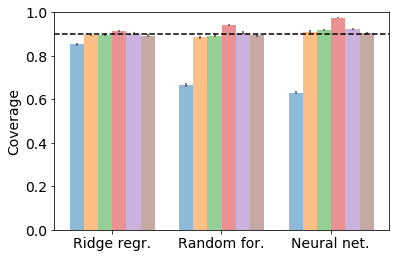

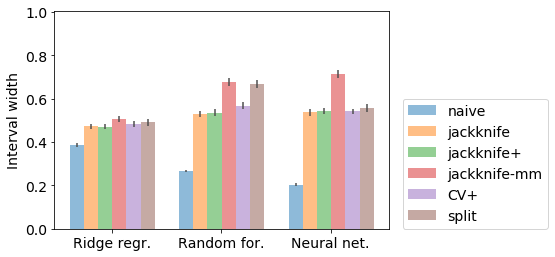

blog


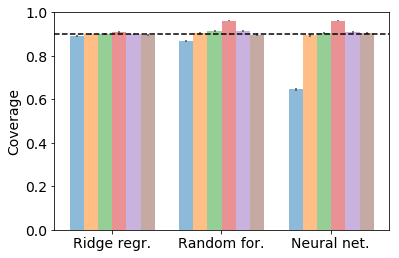

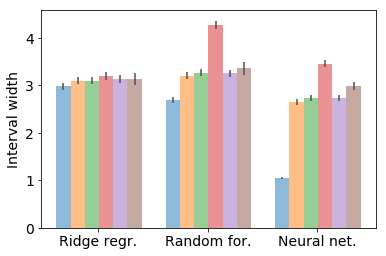

meps


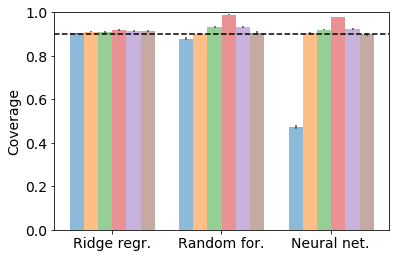

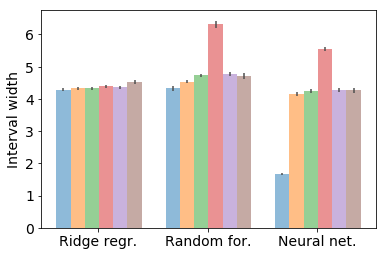

In [6]:
# print(results.head())
# plot real data results
plt.rcParams.update({'font.size': 14})
num_funs=3

for dataset in datasets: 
    print(dataset)
    for method in method_names:
        coverage_mean = results[(results['dataset']==dataset)&\
                    (results['method']==method)].groupby('muh_fun')['coverage'].mean()
        coverage_SE = results[(results['dataset']==dataset)&\
                    (results['method']==method)].groupby('muh_fun')['coverage'].std()\
                        /np.sqrt(ntrial)
        plt.bar(np.arange(num_funs)+method_names.index(method)*0.13-0.32,\
                coverage_mean,0.13,alpha=0.5,\
           yerr = coverage_SE,error_kw={'ecolor': '0.3'},label=method)
    plt.ylabel('Coverage')
    plt.ylim([0,1])
    plt.xticks(np.arange(num_funs),muh_fun_names)
    plt.axhline(0.9,linestyle='dashed',color='black')
    plt.savefig('jackknife_realdata_'+dataset+'_coverage.png',dpi=400,bbox_inches='tight')
    plt.show()

    for method in method_names:
        width_mean = results[(results['dataset']==dataset)&\
            (results['method']==method)].groupby('muh_fun')['width'].mean()
        width_SE = results[(results['dataset']==dataset)&\
            (results['method']==method)].groupby('muh_fun')['width'].std()/np.sqrt(ntrial)
        plt.bar(np.arange(num_funs)+method_names.index(method)*0.13-0.32,\
                width_mean,0.13,alpha=0.5,\
           yerr = width_SE,error_kw={'ecolor': '0.3'},label=method)
    if(dataset==datasets[0]):
        plt.legend(loc=(1.04,0))
        plt.ylim([0,1.5*width_mean.max()])
    plt.ylabel('Interval width')
    plt.xticks(np.arange(num_funs),muh_fun_names)
    plt.savefig('jackknife_realdata_'+dataset+'_width.png',dpi=400,bbox_inches='tight')
    plt.show()